In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Reshape, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import files

# Step 1: Upload Dataset in Colab
print("Please upload your dataset file (e.g., zip file)...")
uploaded = files.upload()

# Extract the uploaded zip file
UPLOAD_PATH = list(uploaded.keys())[0]  # Get the uploaded file name
EXTRACT_PATH = "extracted_dataset"  # Directory to extract dataset

print(f"Extracting {UPLOAD_PATH} to {EXTRACT_PATH}...")
if not os.path.exists(EXTRACT_PATH):
    os.makedirs(EXTRACT_PATH)
with zipfile.ZipFile(UPLOAD_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)

Please upload your dataset file (e.g., zip file)...


Saving dataset.zip to dataset.zip
Extracting dataset.zip to extracted_dataset...


Inspecting extracted dataset...
Directory: extracted_dataset
Subdirectories: ['dataset']
Files: []
Directory: extracted_dataset/dataset
Subdirectories: ['images']
Files: []
Directory: extracted_dataset/dataset/images
Subdirectories: ['test', 'train']
Files: []
Directory: extracted_dataset/dataset/images/test
Subdirectories: []
Files: ['mix (7).jpg', 'mix (6).jpg', 'mix (5).jpg', 'tissue (7).jpg', 'pepsodent (9).jpg']
Directory: extracted_dataset/dataset/images/train
Subdirectories: []
Files: ['mix (7).jpg', 'mix (6).jpg', 'chitato (35).jpg', 'mix (5).jpg', 'tissue (7).jpg']
Loading images from the dataset...
Total images loaded: 380
Generated dummy labels for 380 images.
Building the model...


<ipython-input-6-96315cd9dcde>:54: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=input_shape, include_top=False)


Training the model...
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - bbox_regressor_loss: 279.7770 - bbox_regressor_mse: 281.8062 - class_predictor_accuracy: 0.0636 - class_predictor_loss: 0.1184 - loss: 281.9248 - val_bbox_regressor_loss: 29.6853 - val_bbox_regressor_mse: 29.7262 - val_class_predictor_accuracy: 0.0820 - val_class_predictor_loss: 0.1408 - val_loss: 29.8669
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - bbox_regressor_loss: 0.1369 - bbox_regressor_mse: 0.1372 - class_predictor_accuracy: 0.0931 - class_predictor_loss: 0.0914 - loss: 0.2285 - val_bbox_regressor_loss: 118.5022 - val_bbox_regressor_mse: 118.6192 - val_class_predictor_accuracy: 0.0984 - val_class_predictor_loss: 0.1737 - val_loss: 118.7927
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - bbox_regressor_loss: 0.1279 - bbox_regressor_mse: 0.1283 - class_predictor_accuracy: 0.1600 - class_predictor_loss: 0.0901 - loss: 0.2184 - val_bbox_regressor_loss: 405.4153 - val_bbox_regressor_mse: 405.5118 - va

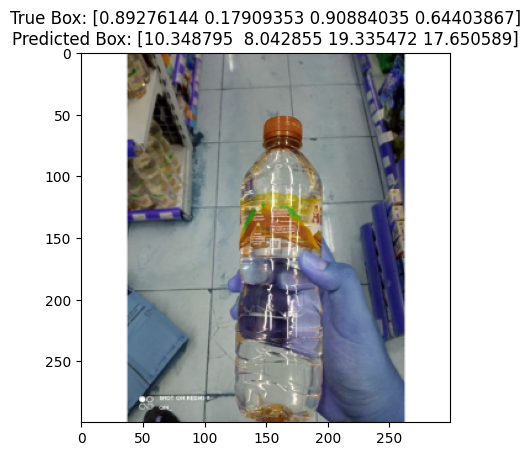

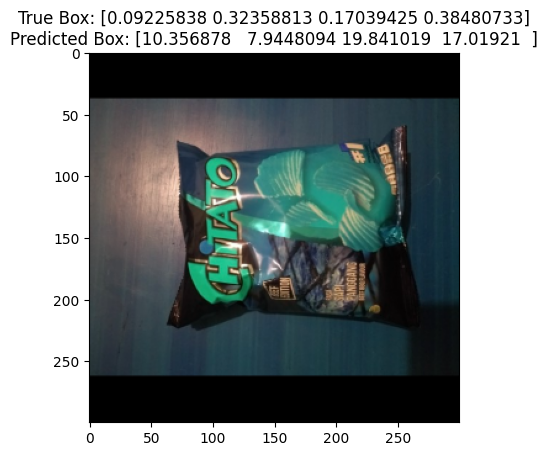

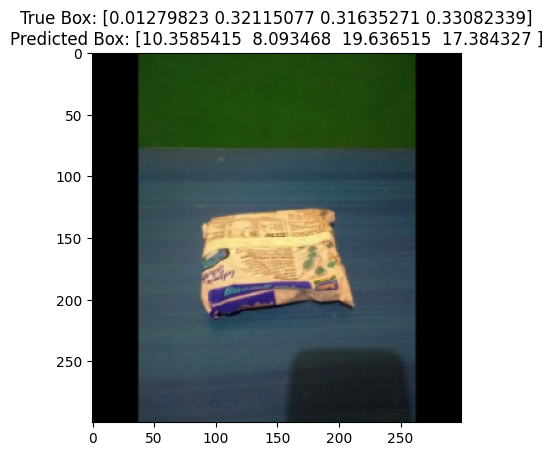

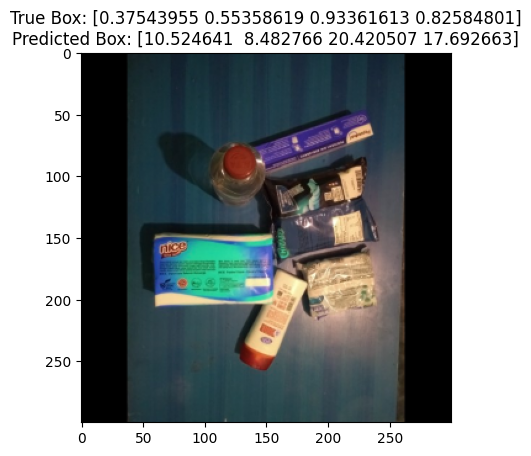

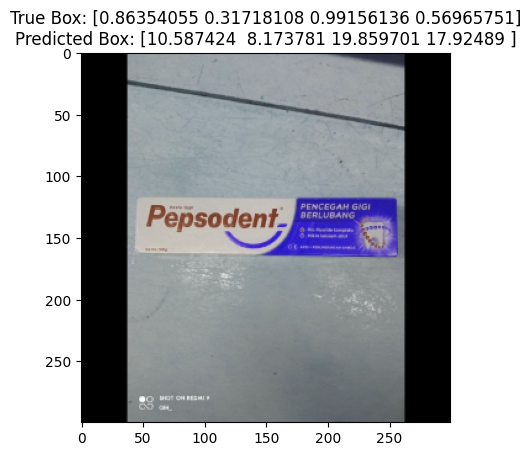

In [ ]:
# Step 2: Inspect the Dataset
print("Inspecting extracted dataset...")
for root, dirs, files in os.walk(EXTRACT_PATH):
    print(f"Directory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {files[:5]}")  # Display first 5 files in each directory

# Step 3: Dataset Preparation (Placeholder for Manual Annotations)
def load_images(data_dir):
    images = []
    image_files = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.resize(image, (300, 300))
                    images.append(image)
                    image_files.append(image_path)
    return np.array(images), image_files

print("Loading images from the dataset...")
images, image_files = load_images(EXTRACT_PATH)

# Normalize images
images = images / 255.0

print(f"Total images loaded: {len(images)}")

# Step 4: Placeholder Labels (Manually Define or Use Annotation Tool)
# NOTE: Replace the following labels with actual annotations for your dataset
# Here, we randomly generate bounding boxes and classes for demonstration purposes.
def generate_dummy_labels(image_count):
    labels = []
    for _ in range(image_count):
        x_min, y_min, x_max, y_max = np.random.rand(4)
        x_min, x_max = sorted([x_min, x_max])  # Ensure x_min < x_max
        y_min, y_max = sorted([y_min, y_max])  # Ensure y_min < y_max
        label = np.random.randint(0, 10)  # Assume 10 classes for demonstration
        labels.append([x_min, y_min, x_max, y_max, label])
    return np.array(labels)

labels = generate_dummy_labels(len(images))
print(f"Generated dummy labels for {len(labels)} images.")

# Step 5: Split Dataset
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Step 6: Build SSD Model
def build_ssd_model(input_shape=(300, 300, 3), num_classes=10):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False)
    x = base_model.output

    # SSD specific layers
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    conv2 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv1)
    flatten = Flatten()(conv2)  # Flatten the output for regression and classification

    # Output layers
    bbox_regressors = tf.keras.layers.Dense(4, activation='linear', name='bbox_regressor')(flatten)  # 4 outputs for bbox coordinates
    class_predictors = tf.keras.layers.Dense(num_classes, activation='softmax', name='class_predictor')(flatten)  # num_classes outputs for class probabilities

    # Concatenate outputs (if needed)
    # outputs = Concatenate(axis=-1)([bbox_regressors, class_predictors])

    # Final model
    model = Model(inputs=base_model.input, outputs=[bbox_regressors, class_predictors])  # Output both bbox and class predictions
    return model

print("Building the model...")
ssd_model = build_ssd_model()

# Compile the model
ssd_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',  # You might need to adjust the loss function for multiple outputs
    metrics=[['mse'], ['accuracy']] # Provide a list of metrics for each output
)

# Step 7: Train the Model
# Step 7: Train the Model
print("Training the model...")
# Convert class labels to one-hot encoding
from tensorflow.keras.utils import to_categorical
train_labels_onehot = to_categorical(train_labels[:, 4], num_classes=10) # Assuming 10 classes

history = ssd_model.fit(
    train_images, [train_labels[:, :4], train_labels_onehot],  # Separate bbox and class labels, use one-hot for class labels
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)

# Step 8: Evaluate the Model
print("Evaluating the model...")
# Assuming test_labels has shape (num_samples, 5)
# where the last column is the class label
test_loss, bbox_loss, class_loss, bbox_mse, class_accuracy = ssd_model.evaluate(
    test_images,
    [test_labels[:, :4], to_categorical(test_labels[:, 4], num_classes=10)],  # Separate bbox and class labels, one-hot encode class labels
    verbose=0  # You can set verbose to 1 for more detailed output
)

print(f"Total Test Loss: {test_loss:.4f}")
print(f"Bounding Box Loss: {bbox_loss:.4f}")
print(f"Class Loss: {class_loss:.4f}")
print(f"Bounding Box MSE: {bbox_mse:.4f}")
print(f"Class Accuracy: {class_accuracy:.4f}")


def visualize_predictions(images, labels, predictions, num_images=5):
    # predictions[0] contains the bounding box predictions
    bbox_predictions = predictions[0]
    for i in range(num_images):
        img = images[i]
        true_box = labels[i][:4]
        # Get the bounding box prediction for the current image
        pred_box = bbox_predictions[i][:4]

        plt.figure()
        plt.imshow(img)
        plt.title(f"True Box: {true_box}\nPredicted Box: {pred_box}")
        plt.show()

predictions = ssd_model.predict(test_images[:5])
visualize_predictions(test_images, test_labels, predictions)
